In [1]:
%matplotlib inline
import numpy as np
from imageio import mimread
import matplotlib.pyplot as plt
from math import ceil
from scipy.signal import convolve2d
from scipy.special import erf
from scipy.signal import gaussian
from scipy.optimize import minimize
import json

# Function definitions

In [2]:
# B-Spline function
#   t: argument
#   q: order
def bspline(t,q):
    if q==1: return 1 if 0<=t<1 else 0
    return (t*bspline(t,q-1)+(q-t)*bspline(t-1,q-1))/(q-1)

In [3]:
# find local maximum within 4-connected neighborhood
def max_n4(d):
    r = d[1:-1,1:]>d[1:-1,:-1]
    m = np.logical_and(r[:,:-1],np.logical_not(r[:,1:]))
    r = d[1:,1:-1]>d[:-1,1:-1]
    m = np.logical_and(m,np.logical_and(r[:-1,:],np.logical_not(r[1:,:])))
    m = np.array(np.where(m))+1
    return list(zip(*m))

In [4]:
# find local maximum within 8-connected neighborhood
def max_n8(d):
    r = d[1:-1,1:]>d[1:-1,:-1]
    m = np.logical_and(r[:,:-1],np.logical_not(r[:,1:]))
    r = d[1:,1:-1]>d[:-1,1:-1]
    m = np.logical_and(m,np.logical_and(r[:-1,:],np.logical_not(r[1:,:])))
    r = d[1:,1:]>d[:-1,:-1]
    m = np.logical_and(m,np.logical_and(r[:-1,:-1],np.logical_not(r[1:,1:])))
    r = d[1:,:-1]>d[:-1,1:]
    m = np.logical_and(m,np.logical_and(r[:-1,1:],np.logical_not(r[1:,:-1])))
    m = np.array(np.where(m))+1
    return list(zip(*m))

In [5]:
# find local maximum within 8-connected neighborhood
#  transposed to match the order of located maxima of ThunderSTORM
def max_n8w(d):
    r = d[1:-1,1:]>d[1:-1,:-1]
    m = np.logical_and(r[:,:-1],np.logical_not(r[:,1:]))
    r = d[1:,1:-1]>d[:-1,1:-1]
    m = np.logical_and(m,np.logical_and(r[:-1,:],np.logical_not(r[1:,:])))
    r = d[1:,1:]>d[:-1,:-1]
    m = np.logical_and(m,np.logical_and(r[:-1,:-1],np.logical_not(r[1:,1:])))
    r = d[1:,:-1]>d[:-1,1:]
    m = np.logical_and(m,np.logical_and(r[:-1,1:],np.logical_not(r[1:,:-1])))
    m = np.array(np.where(m.transpose()))+1
    m = [m[1],m[0]]
    return list(zip(*m))

In [6]:
# 1D Gaussian function (not normalized)
def gaussian_func(x):
    return np.exp(-np.power(x,2))

In [7]:
# Integrated Gaussian Point Spread Function
# p = [xc,yc,sigma,N,bg]
#    sigma, N, and bg are squared to ensure postiveness (following ThunderSTORM)
def psf_ig2(x,y,p):
    s2s = np.sqrt(2)*p[2]**2
    ex = (erf((x-p[0]+0.5)/s2s)-erf((x-p[0]-0.5)/s2s))/2
    ey = (erf((y-p[1]+0.5)/s2s)-erf((y-p[1]-0.5)/s2s))/2
    return ex*ey*p[3]**2+p[4]**2

In [8]:
# negated log likelihood calculation
#   sq: image
#   p: parameters for PSF
def likelihood(sq,p):
    l = sq.shape[0]
    tl = 0
    for x in range(l):
        for y in range(l):
            psf = psf_ig2(x,y,p)
            tl += sq[x,y]*np.log(psf)-psf
    return -tl

In [9]:
# mean square error
def msq_err(sq,p):
    l = sq.shape[0]
    tt = 0
    for x in range(l):
        for y in range(l):
            tt += (sq[x,y]-psf_ig2(x,y,p))**2
    return tt

## Wavelet filter

In [10]:
# Wavelet kernel for convolution
wkq = 3
wk1 = [bspline((i+1)/2,wkq) for i in range(wkq*2-1)]
wk1 = np.array(wk1)/sum(wk1)
wk2 = np.array([[0 if i%2 else wk1[i//2] for i in range(len(wk1)*2-1)]])
wk1 = np.array([wk1])

# fit window range, size of local PSF fit window is 2fwr+1 x 2fwr+1
fwr = 4

In [11]:
# filter raw image and find local maxia from 8-connected neighborhood
def maxi2d(v0):
    global fwr
    global wk1
    global wk2
    r = (wk1.shape[1]-1)//2
    v1 = convolve2d(convolve2d(v0,wk1),wk1.transpose())[r:-r,r:-r]
    r = (wk2.shape[1]-1)//2
    v2 = convolve2d(convolve2d(v1,wk2),wk2.transpose())[r:-r,r:-r]
    f1 = v0-v1
    f2 = v1-v2
    # decide on the threshold
    threshold = 1.5*np.std(f1)
    print('threshold = ', threshold)
    # find local maxima
    return [x for x in max_n8(f2) if
        f2[x]>threshold and
        fwr<=x[0]<f2.shape[0]-fwr and
        fwr<=x[1]<f2.shape[1]-fwr]

In [12]:
# initial parameters of PSF for Nelder-Mead
def init_p(sq):
    z = len(sq)
    mx = np.max(sq)
    mn = np.min(sq)
    return [(z-1)/2,(z-1)/2,np.sqrt(1.6),np.sqrt(mx-mn),np.sqrt(mn)]

In [13]:
# making initial simplex for Nelder--Mead minimization
def ini_simplex(x0):
    steps = [1,1,0.1,3000,10]
    ini = []
    for i in range(len(steps)):
        c = list(x0)
        c[i] += steps[i]
        ini.append(c)
    ini.append(list(x0))
    return ini

In [14]:
# read parameters for localization
prms = json.load(open('../dat/layer_71.tif-protocol.txt'))
# intensity to photon count
i2p = (lambda x:x['photons2ADU']/x['quantumEfficiency'])(prms['cameraSettings'])
# fit window range, size of local PSF fit window is 2fwr+1 x 2fwr+1
fwr = prms['analysisEstimator']['fittingRadius']
# pixel size in nm
plsz = prms['cameraSettings']['pixelSize']

In [15]:
# read images
d = mimread('../dat/layer_71.tif')

In [16]:
mxs = maxi2d(d[0])

threshold =  18.0664946553


In [17]:
# some problematic example for maximum-likelihood fitting
i = 2
cx,cy = mxs[i]
sq = d[0][cx-fwr:cx+fwr+1,cy-fwr:cy+fwr+1]*i2p

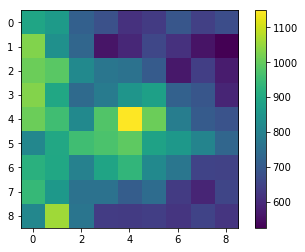

In [18]:
plt.imshow(sq)
plt.colorbar()
plt.show()

In [19]:
x0 = init_p(sq)
ispx = ini_simplex(x0)

In [20]:
res = minimize(lambda x:msq_err(sq,x),x0,method='Nelder-Mead')#,options={'initial_simplex':ispx})
print(res.x)

[   4.46495343    0.6053928     2.10524353  231.08908375   22.87860082]


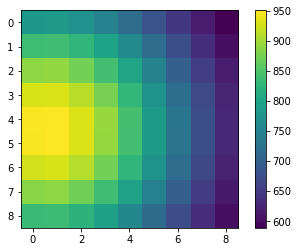

In [21]:
plt.imshow([[psf_ig2(x,y,res.x) for y in range(2*fwr+1)] for x in range(2*fwr+1)])
plt.colorbar()
plt.show()

In [22]:
# fix calculated values to physical values
#   shift center to absolute coordinate
#   pixel size => nm
#   square the positive parameters
def fix_p(c,p):
    return [(c[1]+p[1]-fwr)*plsz,(c[0]+p[0]-fwr)*plsz,plsz*p[2]**2,p[3]**2,p[4]**2]

In [23]:
# calcuate for an image
def calc_image(im):
    rs = []
    mxs = maxi2d(im)
    for m in mxs:
        sq = im[m[0]-fwr:m[0]+fwr+1,m[1]-fwr:m[1]+fwr+1]*i2p
        r = minimize(lambda x:msq_err(sq,x),init_p(sq),method='Nelder-Mead')
        rs.append(fix_p(m,r.x))
    return rs

In [24]:
results = calc_image(d[0])

threshold =  18.0664946553


In [25]:
# read the csv file created by ThunderSTORM
def ts_csv(fn,n):
    f = open(fn)
    f.readline()
    s1 = []
    for l in f:
        t = l.split(',')
        if t[0]!=str(n): continue
        s1.append([float(i) for i in t[1:]])
    return s1

In [26]:
tstorms = ts_csv('../dat/layer_71.tif.csv',1)

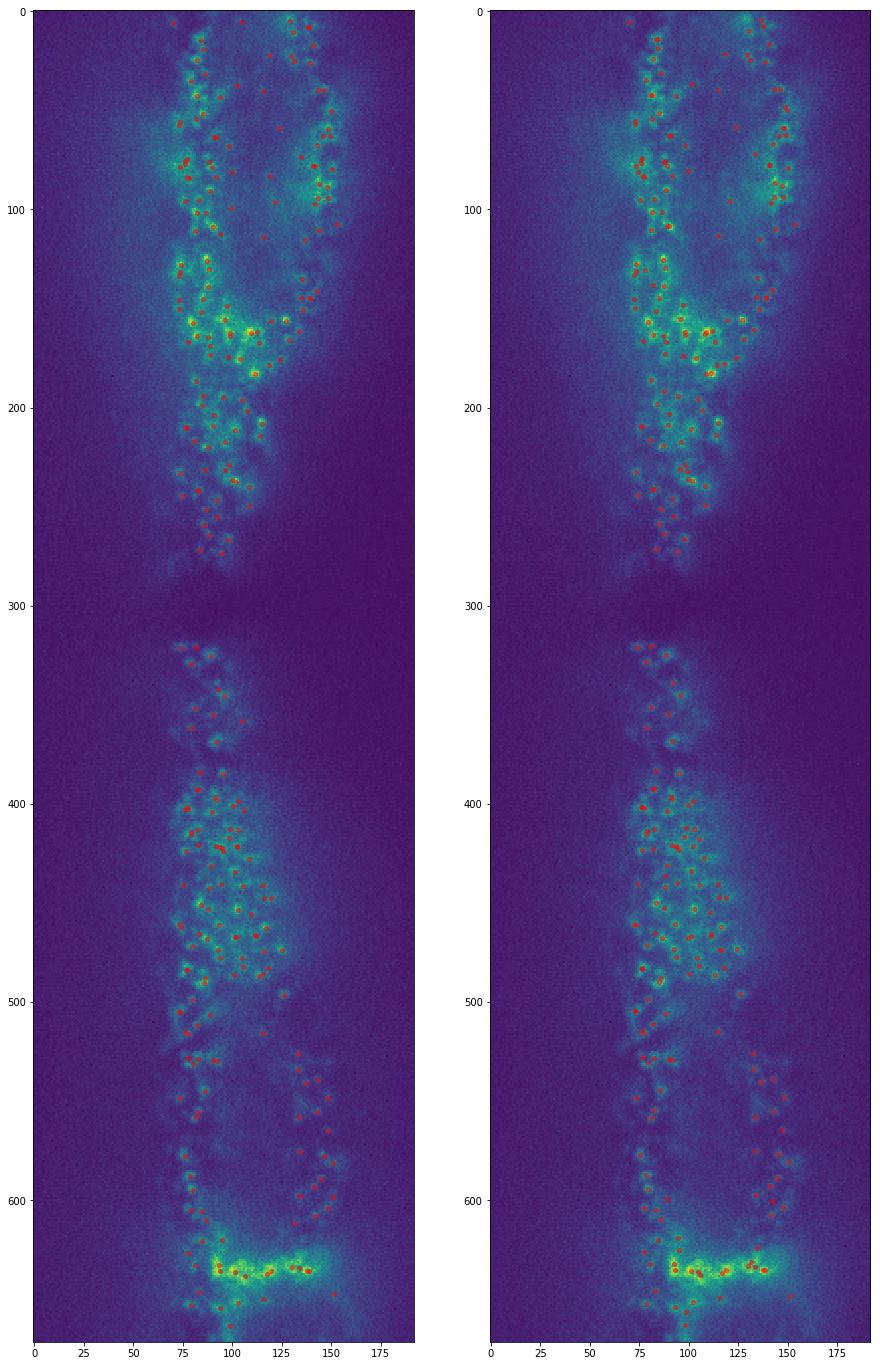

In [27]:
plt.figure(figsize=(15,30))
plt.subplot(1,2,1)
plt.imshow(d[0])
plt.plot(*(np.array(list(zip(*tstorms))[:2])/80),'ro',markersize=4,alpha=0.5)
plt.subplot(1,2,2)
plt.imshow(d[0])
plt.plot(*(np.array(list(zip(*results))[:2])/80),'ro',markersize=4,alpha=0.5)
plt.show()